# Prepare subset of Coco data to use for our project

The full Coco training dataset has almost 120k images. This is too much to train our model on!

We could randomly sample from this data to create a train/val/test dataset.

To make our task slightly easier to start with, we could also select images containing only certain categores. After exploring the data and selecting all images with 'sports' as a super category, we find that we have ~23k images, which seems more manageable.

We will split this up in to 18k training and 5k validation images.

We then use the validation dataset to find a test dataset.

In [16]:
import json
from pathlib import Path
from PIL import Image as PILImage
from matplotlib import pyplot as plt
import random
import numpy as np
import sys
from Vocabulary import Vocabulary
from MSCOCO import COCO

In [17]:
annotations_folder = Path(r'Datasets/coco/annotations')
image_folder = Path(r'Datasets/coco/images/train2017')
image_folder_test = Path(r'Datasets/coco/images/val2017')

Load the json files. We do not use instances_train2017.json in our training, but we need it to reduce the size of our dataset via super-category selection.

In [18]:
STAGE = 'train'
# STAGE = 'val'
TRAIN_PCT = 0.87
instances_file = annotations_folder/f'instances_{STAGE}2017.json'
captions_file = annotations_folder/f'captions_{STAGE}2017.json'

with open(instances_file) as f:
    instances = json.load(f)
with open(captions_file) as f:
    captions = json.load(f)

### Choose only images containing categories in certain super categories

* Define the categories / super categories we want to use
* Iterate through the annotations file, to extract all image ids with our selected categories in
* Remove suplicate image from the list
* Print some random images from our dataset

Also create an annotations list which is the subset of the full `instances['annotations']` list that we are interested in.

In [19]:
instances['categories']

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [20]:
supers = ['sports']
supers = ['animal','sports', 'appliance', 'electronic', 
          'indoor', 'furniture', 'food', 'kitchen', 
          'vehicle', 'person', 'outdoor']
ids = []
id_dict = {}
id_to_name = dict(zip([cat['id'] for cat in instances['categories']],
                     [cat['name'] for cat in instances['categories']]))
for d in instances['categories']:
    if d['supercategory'] in supers:
        ids.append(d['id'])
        id_dict[d['id']] = d['name']
id_dict

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mouse',
 75: 'remote',
 76: 'keyboard',
 77: 'cell phone',
 78: 'microwave',
 79:

Create the following:

* `img_list` - a list of all images with a sports supercategory in
* `full_img_list` - this is just the full list of images contained in the entire annotations dict. It is the complete training set.
* `annotations` - list which is a subset of instances['annotations'] - it just consists of the annotations where the object is a member of the sports supercategory.

In [21]:
img_list = []
full_img_list = [int(f.stem) for f in image_folder.glob('**/*')]
annotations = []
for d in instances['annotations']:
    # full_img_list.append(d['image_id'])
    if d['category_id'] in ids:
        img_list.append(d['image_id'])
        annotations.append(d)
img_list = list(set(img_list))
print(len(img_list))

116849


Now create a smaller version of the captions.json file

`new_captions_list` is the new list of captions to replace captions['annotations'] in the json file. We create a val and train file.

We create a list of file paths for our training data, and a list of file paths for our validation data.

Also an captions file for both too.

In [22]:
rng = np.random.default_rng(42)
imgs_train = rng.choice(img_list,
                        size =int(TRAIN_PCT * len(img_list)),
                        replace=False)
imgs_val = list(set(img_list).difference(set(imgs_train)))

# if len(imgs_train > 15000):
#     imgs_train = imgs_train[:500]
# if len(imgs_val) > 3000:
#     imgs_val = imgs_val[:100]

captions_full = dict(zip(full_img_list, 
                         [[] for _ in range(len(full_img_list))]))
images_dict = dict(zip(full_img_list, 
                         [[] for _ in range(len(full_img_list))]))

for d in captions['annotations']:
    captions_full[d['image_id']].append(d)
    
for d in captions['images']:
    images_dict[d['id']].append(d)

def create_lists(img_list, capts_dict, imgs_dict):
    new_capt_list = []
    new_img_list = []
    for img_id in img_list:
        new_capt_list.extend(capts_dict[img_id])
        new_img_list.extend(imgs_dict[img_id])
    return new_capt_list, new_img_list
        
n_capt_list_train, n_img_list_train = create_lists(imgs_train,
                                                   captions_full,
                                                   images_dict)
n_capt_list_val, n_img_list_val = create_lists(imgs_val,
                                               captions_full,
                                               images_dict)

new_captions_train = {'info': captions['info'],
                    'images': n_img_list_train,
                    'annotations': n_capt_list_train}

new_captions_val = {'info': captions['info'],
                    'images': n_img_list_val,
                    'annotations': n_capt_list_val}

train_img_paths = {'image_paths': [image_folder/(str(id).zfill(12) + '.jpg')
                                   for id in imgs_train]}

val_img_paths = {'image_paths': [image_folder/(str(id).zfill(12) + '.jpg')
                                   for id in imgs_val]}

In [23]:
len(imgs_train), len(imgs_val)

(500, 100)

### Now do the same for the test files

We use the original coco validation set to create our test files

In [24]:
STAGE = 'val' # we are using coco validation set for our test set
instances_file = annotations_folder/f'instances_{STAGE}2017.json'
captions_file = annotations_folder/f'captions_{STAGE}2017.json'

with open(instances_file) as f:
    instances_test = json.load(f)
with open(captions_file) as f:
    captions_test = json.load(f)
    
img_list_test = []
full_img_list_test = [int(f.stem) for f in image_folder_test.glob('**/*')]
annotations_test = []
for d in instances_test['annotations']:
    # full_img_list.append(d['image_id'])
    if d['category_id'] in ids:
        img_list_test.append(d['image_id'])
        annotations_test.append(d)
img_list_test = list(set(img_list_test))

captions_full_test = dict(zip(full_img_list_test, 
                         [[] for _ in range(len(full_img_list_test))]))
images_dict_test = dict(zip(full_img_list_test, 
                         [[] for _ in range(len(full_img_list_test))]))

for d in captions_test['annotations']:
    captions_full_test[d['image_id']].append(d)
    
for d in captions_test['images']:
    images_dict_test[d['id']].append(d)

n_capt_list_test, n_img_list_test = create_lists(img_list_test,
                                                 captions_full_test,
                                                 images_dict_test)

new_captions_test = {'info': captions_test['info'],
                    'images': n_img_list_test,
                    'annotations': n_capt_list_test}

test_img_paths = {'image_paths': [image_folder_test/(str(id).zfill(12) + '.jpg')
                                   for id in img_list_test]}

### Save all files to new json files

In [25]:
save_files = {'sports_captions_train': new_captions_train,
              'sports_captions_val': new_captions_val,
              'sports_captions_test': new_captions_test,
              # 'sports_imgs_train': train_img_paths,
              # 'sports_imgs_train': val_img_paths,
              # 'sports_imgs_train': test_img_paths,
             }

for key, val in save_files.items():
    with open(annotations_folder/f'{key}.json', 'w') as json_file:
        json.dump(val, json_file)

### Test that files have been saved correctly and that images are not shared between stages

Looks like we have distinct images for each test set. It was worth doing this test because I had a typo in the notebook on first run, and the train and val image set were the same.

In [26]:
for key, val in save_files.items():
    with open(annotations_folder/f'{key}.json', 'r') as f:
        val = json.load(f)

def create_img_list(images):
    imgs = []
    for d in images:
        imgs.append(d['file_name'])
    if len(imgs) != len(set(imgs)): print('duplicates found')
    return imgs

train_imgs = create_img_list(new_captions_train['images'])
val_imgs = create_img_list(new_captions_val['images'])
test_imgs = create_img_list(new_captions_test['images'])

# check for duplicate images and print length of data sets

print(f"train set has {len(train_imgs)} images")
print(f"val set has {len(val_imgs)} images")
print(f"test set has {len(test_imgs)} images\n")
print(f"common images in train and val: {set(train_imgs).intersection(set(val_imgs))}")
print(f"common images in train and test: {set(train_imgs).intersection(set(test_imgs))}")
print(f"common images in val and test: {set(val_imgs).intersection(set(test_imgs))}")

train set has 500 images
val set has 100 images
test set has 4939 images

common images in train and val: set()
common images in train and test: set()
common images in val and test: set()


## Visualise some of the training set

Now extract list of categories in each image. We can have many different categories, not just sports. We have selected only images that show sports objects - but the images can show any other type of object too.

In [27]:
cats = dict(zip(img_list, [[] for _ in range(len(img_list))]))
cats_full = dict(zip(full_img_list, [[] for _ in range(len(full_img_list))]))
for d in instances['annotations']:
    cats_full[d['image_id']].append(d['category_id'])

for k in img_list:
    cats[k] = cats_full[k]
    

Visualise some of the images. Print out all the categories shown in the images below.

image 0:
person, toilet, toothbrush
----------
A man brushing his teeth while taking a selfie.
A man taking a selfie of himself brushing his teeth.
Man brushing his teeth while taking a photo of himself.
A man is brushing his teeth while holding a camera.
A man taking a picture of himself as he brushes his teeth.
----------

image 1:
skis, person
----------
A person skiing down a snowy mountain side.
The man is racing down the hill skiing. 
A young person that is having fun skiing down a slope.
A person skiing alone in the snow capped area
a man that is skiing down a snowy hill
----------

image 2:
person, kite
----------
A person para sailing in the ocean on a windy day
A person parasails in water with mountains in the background.
Kitesurfing on the ocean in a mountainous area
A person kite surfacing with mountains and trees in the background.
A person is jet sking with a kite 
----------

image 3:
baseball bat, baseball bat, person, person, person, person, person, person, person, per

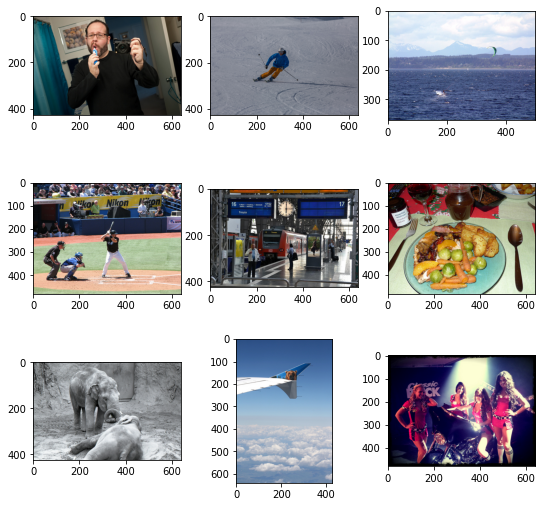

In [28]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize=(9,9))

for i, ax in enumerate(axs.flatten()):
    image_id = img_list[random.randint(0, len(img_list))]
    f = image_folder/(str(image_id).zfill(12) + '.jpg')
    im = PILImage.open(f)
    ax.imshow(im)
    categories = [id_to_name[cat] for cat in cats[image_id]]
    captions = [capt['caption'] for capt in captions_full[image_id]]
    print('image {}:'.format(i))
    print(', '.join(categories))
    print('-'*10)
    print('\n'.join(captions))
    print('-'*10)
    print('')